In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import cv2

In [2]:
# For U-Net
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data cleaning

The objective of this section is to clearly separate the train and test dataset.

In [4]:
# The images and labels are to be loaded from the following sources
IMG_BASE = '/kaggle/input/covidxct/3A_images/'
LABELS_train = '/kaggle/input/covidxct/train_COVIDx_CT-3A.txt'
LABELS_test = '/kaggle/input/covidxct/test_COVIDx_CT-3A.txt'
SUMMARY = '/kaggle/input/covidxct/metadata.csv'

# Class names, in order of index
CLASSES = ('NORMAL', 'PNEUMONIA', 'COVID-19')

# Checkpoints available at
CHECKPOINT = "CT.keras"

# Define the dimensions of the image
height = 256
width = 256

# Define a seed for all randomisations
seed = 22

In [5]:
# The following modules will be employed for pre-processing the training data

def process_row(row):
    fname, cls, xmin, ymin, xmax, ymax = row.strip('\n').split()
    bboxes = (int(xmin), int(ymin), int(xmax), int(ymax))
    
    image = load_img(IMG_BASE, fname, bboxes)

    return image, cls
    

def load_img(IMG_BASE, fname, bbox=None):
    """Loads and preprocesses images for inference"""
    image_file = IMG_BASE + fname
    # Load and crop image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if bbox is not None:
        image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    image = cv2.resize(image, (width, height), cv2.INTER_CUBIC)

    # Convert to float in range [0, 1]
    image = image.astype(np.float32) / 255.0

    # Shift to tensorflow
    image =  tf.image.convert_image_dtype(image, dtype=tf.float32)
    return tf.reshape(image, [height, width, 1])

def find_row_with_string(filename, search_string):
    try:
        with open(filename, 'r') as file:
            for line in file:
                if search_string in line:
                    # The below randomisation is to ensire that the other CT images are also accessed and not just the first one
                    # This is to help increase the amount of training data used
                    if random.random() < 1/5:
                        return line.strip()
                    else:
                        pass
    except FileNotFoundError:
        print("File not found.")

# Data retrieval

In [6]:
df = pd.read_csv(SUMMARY)
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality
0,CP_0,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
1,CP_10,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
2,CP_1068,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
3,CP_1070,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
4,CP_1071,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT


In [7]:
Diagnoses = df['finding'].unique()

# Split the DataFrame based on the 'finding' column
df_covid = df[df['finding'] == 'COVID-19']
df_pneumonia = df[df['finding'] == 'Pneumonia']
df_normal = df[df['finding'] == 'Normal']

data = [df_normal, df_pneumonia, df_covid]

for diag in data:
    print(diag.count())

patient id          649
source              649
country             642
sex                 366
age                 366
finding             649
verified finding    649
slice selection       0
view                649
modality            649
dtype: int64
patient id          932
source              932
country             901
sex                  95
age                  95
finding             932
verified finding    932
slice selection     932
view                932
modality            932
dtype: int64
patient id          4487
source              4487
country             3823
sex                 2516
age                 2487
finding             4487
verified finding    4487
slice selection     4487
view                4487
modality            4487
dtype: int64


In [8]:
def DataProd(n, label_src):
    # n gives the number of samples from each class to be included in the dataset produced

    x_list = []
    y_list = []
    error = 0

    y_i = 0

    for diag in data:
        samp = diag.sample(n) # Randomly sample n elements from the dataset
    
        for index, row in samp.iterrows():
            try:
                img_data = find_row_with_string(label_src, row['patient id'])
                x, y = process_row(img_data)
                x_list.append(x)
                if int(y) == (y_i): # this is to verify that the images are labelled appropriately in the text files
                    y_list.append(int(y))
                else:
                    print("Fatal Data Flaw. Data in text file modified!")
                    print("Classes:", y, y_i)
                    y_list.append(int(y_i))
            except:
                error += 1
                pass

        y_i += 1

    print("The missing rate for images is ", error / ( len(y_list) + error))
    print("The number of images is ", len(y_list))

    indices = random.sample(range(len(x_list)), len(x_list))

    x_list = [x_list[i] for i in indices]
    y_list = [y_list[i] for i in indices]

    return tf.stack(x_list), tf.constant(y_list)

In [9]:
x_list, y_list = DataProd(50, LABELS_train)

Fatal Data Flaw. Data in text file modified!
Classes: 2 1
The missing rate for images is  0.4
The number of images is  90


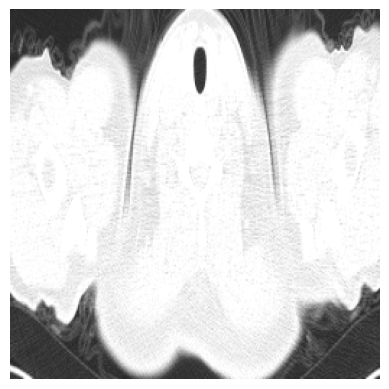

NORMAL


In [10]:
index = 12
# Test what the image looks like
plt.imshow(x_list[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(CLASSES[y_list[index]])

# Model Building

In [11]:
model = tf.keras.Sequential()

model.add(layers.Input(shape=(height, width, 1)))

# Convolution layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# Output layer with 3 neurons (for classification into 3 classes)
model.add(layers.Dense(3, activation='softmax'))  # Use softmax for multi-class classification

learning_rate = 0.0005 # Define the learning rate for the neural network

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['mean_squared_error', 'accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,878,467 (64.39 MB)

 Trainable params: 16,878,467 (64.39 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
num_batches = 10
batch_size = 50 # The actual size of batch will be approximately batch_size * 3 * 0.7
epochs = 15
training_runs = 10

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT,
                                                 verbose=1,
                                                 monitor="val_accuracy",
                                                 save_best_only=True,
                                                 mode="max",)

In [13]:
# Use this code to restore the model from the checkpoint
# model.load_weights(CHECKPOINT)

Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 2 1
The missing rate for images is  0.41
The number of images is  885
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3702 - loss: 1.2281 - mean_squared_error: 0.2278
Epoch 1: val_accuracy improved from -inf to 0.53933, saving model to CT.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.3711 - loss: 1.2232 - mean_squared_error: 0.2275 - val_accuracy: 0.5393 - val_loss: 1.0163 - val_mean_squared_error: 0.2043
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4813 - loss: 0.9983 - mean_squared_error: 0.2015
Epoch 2: val_accuracy improved from 0.53933 to 0.73034, saving model to CT.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 6

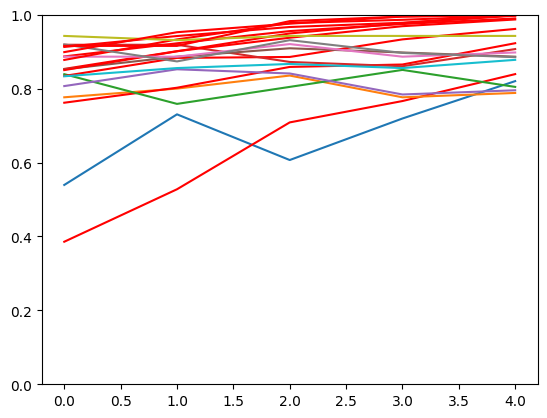

In [14]:
for i in range(training_runs):
    x_list, y_list = DataProd(num_batches * batch_size, LABELS_train)
    y_train = tf.one_hot(y_list, 3).numpy()
    
    history = model.fit(
        x_list,
        y_train,
        batch_size=batch_size,
        epochs=5,
        validation_split=0.1,
        callbacks=[cp_callback],
    ) 
    
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'], color='red')
    plt.ylim(0, 1)

In [15]:
# There is a bit of overfitting that needs to be addressed

In [16]:
def PredictType(image):
    # This function returns the class of the image in terms of its position in CLASSES
    pred = model.predict(tf.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]) ))
    return tf.math.argmax(pred[0])

## Model testing

In [17]:
def GetMetrics(x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = (y_pred > 0.5).astype('int32')
    y_pred_classes = [np.argmax(y_pred_classes[i]) for i in range(len(y_pred_classes))]
    y_pred_classes = np.array(y_pred_classes)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=CLASSES)
    
    # Print metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC: {auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    disp.plot()
    plt.show()

Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 2 1
The missing rate for images is  0.8583333333333333
The number of images is  85
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 901ms/step
Accuracy: 0.7647058823529411
Precision: 0.7953388372893017
Recall: 0.7647058823529411
AUC: 0.8746732558161129
Confusion Matrix:
[[44  3  2]
 [ 3 13  9]
 [ 1  2  8]]


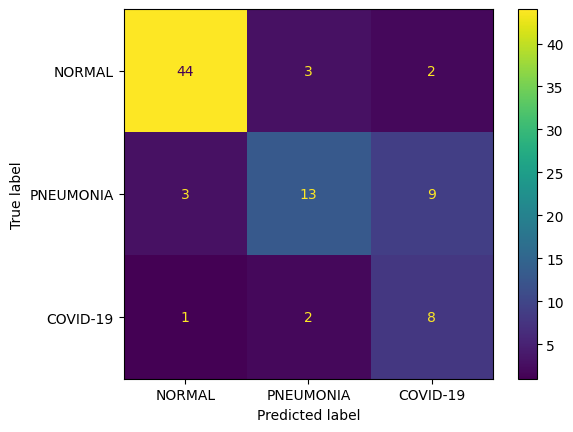

In [18]:
# Get the test data first of all
x_test, y_test = DataProd(200, LABELS_test)

# Calculate the metrics
GetMetrics(x_test, y_test)

# Segmentation model

## Create masked images

In [19]:
num_box = 16

def ImageMaskGenerator(image):
    """
    Takes a 256x256x1 grayscale image and returns 256 images,
    each with one distinct num_box x num_box box filled with its average pixel value.
    
    Args:
        image (tf.Tensor): A 256x256x1 grayscale image.

    Returns:
        List[tf.Tensor]: List of 256 images with averaged boxes.
    """
    if image.shape != (256, 256, 1):
        raise ValueError("Input image must have shape (256, 256, 1)")

    images_with_averaged_boxes = []

    # Create 16x16 boxes
    for row in range(num_box):
        for col in range(num_box):
            # Create a copy of the image
            modified_image = tf.identity(image)

            # Calculate the start and end indices for the box
            start_row, end_row = row * num_box, (row + 1) * num_box
            start_col, end_col = col * num_box, (col + 1) * num_box

            # Calculate the average pixel value in the box
            box = image[start_row:end_row, start_col:end_col, 0]
            avg_value = tf.reduce_mean(box)

            # Fill the box with the average value
            modified_image = tf.tensor_scatter_nd_update(
                modified_image,
                indices=tf.constant(
                    [[r, c, 0] for r in range(start_row, end_row) for c in range(start_col, end_col)],
                    dtype=tf.int32
                ),
                updates=tf.fill([num_box * num_box], avg_value)
            )

            images_with_averaged_boxes.append(modified_image)

    return tf.stack(images_with_averaged_boxes)

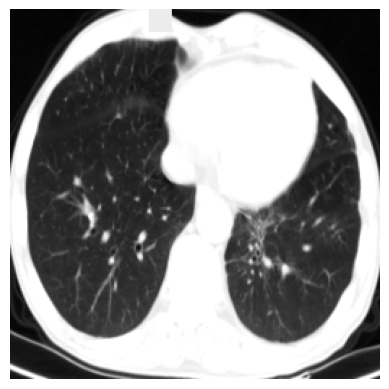

PNEUMONIA


In [20]:
index = 6
i_data = 77
MImg = ImageMaskGenerator(x_list[i_data])
# Test what the image looks like
plt.imshow(MImg[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(CLASSES[y_list[i_data]])

## Feed images in NN and see deviation

In [21]:
def GetRef(image):
    pred = model.predict(tf.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]) ))
    ref = tf.math.reduce_max(pred)
    return ref

def normalize_and_reshape(tensor: tf.Tensor) -> tf.Tensor:
    """
    Normalizes a TensorFlow tensor of length num_box*num_box to [0, 1] and reshapes to num_box x num_box.

    Args:
        tensor (tf.Tensor): A TensorFlow tensor of length num_box * num_box.

    Returns:
        tf.Tensor: A 16x16 TensorFlow image.
    """
    if tensor.shape != (num_box * num_box,):
        raise ValueError("Input tensor must have shape (num_box * num_box,)")

    # Normalize the tensor to [0, 1]
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val + 1e-7)

    # Reshape the tensor into a 16x16 image
    image = tf.reshape(normalized_tensor, (num_box, num_box, 1))

    return tf.image.resize(image, (256, 256) ,method="mitchellcubic")

In [22]:
img_segment = x_list[3]

MImg = ImageMaskGenerator(img_segment)
res = model.predict(MImg)
ref = GetRef(img_segment)
cls = int(PredictType(img_segment))

print(f"This image is of type {CLASSES[cls]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
This image is of type COVID-19


In [23]:
mask_probs = []

for r in res:
    if r[cls] < ref:
        mask_probs.append(ref - r[cls])
    else:
        mask_probs.append(0)

mask_probs = tf.stack(mask_probs)

In [24]:
masks = normalize_and_reshape(mask_probs)

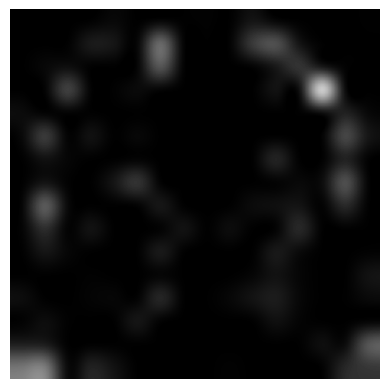

In [25]:
# Visualise the effects the different masks have on the image
plt.imshow(masks, cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

In [26]:
def overlay_red_highlight(base_image: tf.Tensor, overlay_image: tf.Tensor) -> tf.Tensor:
    """
    Overlays a red highlight on the CT image using the greyscale masks.

    Args:
        base_image (tf.Tensor): A 256x256x1 grayscale image.
        overlay_image (tf.Tensor): A 256x256x1 grayscale image.

    Returns:
        tf.Tensor: A 256x256x3 RGB image with red highlights.
    """
    if base_image.shape != (256, 256, 1) or overlay_image.shape != (256, 256, 1):
        raise ValueError("Both images must have shape (256, 256, 1)")

    # Normalize overlay image to [0, 1]
    min_val = tf.reduce_min(overlay_image)
    max_val = tf.reduce_max(overlay_image)
    normalized_overlay = (overlay_image - min_val) / (max_val - min_val + 1e-7)

    # Create RGB channels
    red_channel = base_image + normalized_overlay
    green_channel = base_image
    blue_channel = base_image

    # Concatenate to get an RGB image
    rgb_image = tf.concat([red_channel, green_channel, blue_channel], axis=-1)

    return rgb_image

In [27]:
segmented_img = overlay_red_highlight(img_segment, masks)

In [28]:
def ShowMasks(img_segment): # This function combines all the functionality that was implemented above
    MImg = ImageMaskGenerator(img_segment)
    res = model.predict(MImg)
    ref = GetRef(img_segment)
    cls = int(PredictType(img_segment))
    
    print(f"This image is of type {CLASSES[cls]}")

    mask_probs = []
    
    for r in res:
        if r[cls] < ref:
            mask_probs.append(ref - r[cls])
        else:
            mask_probs.append(0)
    
    mask_probs = tf.stack(mask_probs)
    masks = normalize_and_reshape(mask_probs)

    return masks, cls

In [29]:
masks, cls = ShowMasks(x_list[4])

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
This image is of type PNEUMONIA


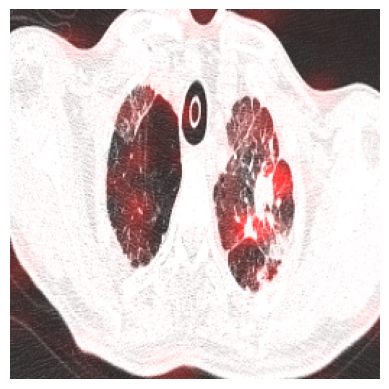

The red highlighted segments show the regions that indicate that the image corresponds to PNEUMONIA.


In [30]:
# Visualise the effects the different masks have on the image
plt.imshow(overlay_red_highlight(x_list[4], masks), vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

# If the entire image is red-tinted, then it is a strong indication that the classification is incorrect.

print(f"The red highlighted segments show the regions that indicate that the image corresponds to {CLASSES[cls]}.")

## U Net approach

In [41]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [42]:
input_shape = (height, width, 1)

Umodel = build_unet(input_shape)
Umodel.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
Umodel.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 256, 256, 64)   │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 128, 128, 64)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 128)  │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 128)  │            512 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8      

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [33]:
mask_list = []
list_items = 40

for x in x_list[0:list_items]:
    y_img, cls = ShowMasks(x)
    mask_list.append(y_img)

mask_list = tf.stack(mask_list)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
This image is of type COVID-19
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
This image is of type COVID-19
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This image is of type PNEUMONIA
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This image is of type COVID-19
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This image is of type PNEUMONIA
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This image is of type COVID-19
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This im

In [34]:
mask_test = []
test_items = 10

for x in x_test[0:test_items]:
    y_img, cls = ShowMasks(x)
    mask_test.append(y_img)

mask_test = tf.stack(mask_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
This image is of type NORMAL
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
This image is of type COVID-19
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
This image is of type PNEUMONIA
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
This image is of type NORMAL
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
This image is of type NORMAL
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This image is of type NORMAL
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
This image is of

In [39]:
U_Net_Batch_size = 8

# This helps to augument the little data that is available to the model

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
# image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow(x_list[0:list_items], seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(x_test[0:test_items], seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(mask_list, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(mask_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [ ]:
history = Umodel.fit(x_list[0:list_items], mask_list,
                    epochs=10,
                    validation_data=(x_test[0:test_items], mask_test))

In [45]:
steps_per_epoch = 50
U_CHECKPOINT = "UNet.keras"
epochs = 10

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=U_CHECKPOINT,
                                                 verbose=1,
                                                 monitor="val_accuracy",
                                                 save_best_only=True,
                                                 mode="max",)


history = Umodel.fit(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=epochs,
                    callbacks=[cp_callback])

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 143s/step - accuracy: 0.7959 - loss: 0.5058  
Epoch 1: val_accuracy improved from -inf to 0.40361, saving model to UNet.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 7639s 153s/step - accuracy: 0.7960 - loss: 0.5054 - val_accuracy: 0.4036 - val_loss: 0.9362
Epoch 2/10
30/50 ━━━━━━━━━━━━━━━━━━━━ 48:20 145s/step - accuracy: 0.8056 - loss: 0.4702

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


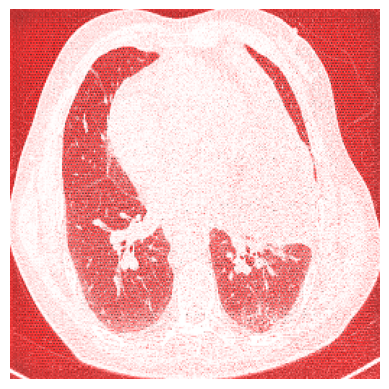

In [55]:
index = -1

sample_res = Umodel.predict(tf.reshape(x_list[index], (1, 256, 256, 1)))

sample_res = tf.reshape(sample_res, (256, 256, 1))

# Visualise the effects the different masks have on the image
plt.imshow(overlay_red_highlight(x_list[index], sample_res), vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

del index

# Severity identification

In [46]:
# Here we look at the Per-COVID 19 dataset
PER_IMG_BASE = '/kaggle/input/per-covid-19/Database1/Images/'
PER_LABELS_BASE = '/kaggle/input/per-covid-19/'

SEG_CHECKPOINT = "Severity.keras"

columns = ["Image Name", "COVID-19 Infection Percentage", "Fold Split", "Subject ID"]

dfs = pd.read_excel(PER_LABELS_BASE + 'Database_new.xlsx', header=None, names=columns)

In [ ]:
y_sev = []
x_img = []

for index, row in dfs.iterrows():
    y_sev.append(row[columns[1]])
    x_img.append(load_img(PER_IMG_BASE, row[columns[0]]))

# For the purpose to enabing the neural network to process the y_values, tranform them to between 0 and 1
y_sev = [k/100 for k in y_sev]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_img, y_sev, test_size=0.1, random_state=11)

X_train = tf.stack(X_train)
X_test = tf.stack(X_test)
y_train = tf.constant(y_train)
y_test = [k * 100 for k in y_test]

In [ ]:
index = 111
# Test what the image looks like
plt.imshow(x_img[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(f"This image is {y_sev[index] * 100}% infected")

In [ ]:
def sample_images_with_labels(tensor: tf.Tensor, labels: tf.Tensor, num_samples: int = 300):
    """
    Randomly samples `num_samples` images and their corresponding labels.
    
    Parameters:
        tensor (tf.Tensor): Input tensor of shape (n, 256, 256, 1), where n > num_samples.
        labels (tf.Tensor or list): Corresponding labels of shape (n,).
        num_samples (int): Number of images to sample. Default is 300.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing:
            - Sampled images tensor of shape (num_samples, 256, 256, 1).
            - Sampled labels tensor of shape (num_samples,).
    """
    n = tf.shape(tensor)[0]
    assert n > num_samples, "Input tensor must have more than 300 images."
    assert tf.shape(labels)[0] == n, "Labels must have the same number of elements as images."
    
    indices = tf.random.shuffle(tf.range(n))[:num_samples]
    sampled_tensor = tf.gather(tensor, indices)
    sampled_labels = tf.gather(labels, indices)
    
    return sampled_tensor, sampled_labels

In [ ]:
SegModel = tf.keras.Sequential()

SegModel.add(layers.Input(shape=(height, width, 1)))

# Convolution layers
SegModel.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
SegModel.add(layers.MaxPooling2D((2, 2)))

SegModel.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
SegModel.add(layers.MaxPooling2D((2, 2)))

SegModel.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
SegModel.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
SegModel.add(layers.Flatten())

# Fully connected layers
SegModel.add(layers.Dense(128, activation='relu'))
SegModel.add(layers.Dense(64, activation='relu'))

# Output layer with 1 neurons (for the predicted value)
SegModel.add(layers.Dense(1, activation='sigmoid'))  # Use sigmoid for regression

learning_rate = 0.0005 # Define the learning rate for the neural network

SegModel.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error', 'accuracy'])

SegModel.summary()

# The main challenege in training a regression model is to ensure that the model 
# does not settle at just predicting the mean value of the datatset.

In [ ]:
epochs = 5
batch_size = 200
num_bacthes = 5
training_runs = 1

seg_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=SEG_CHECKPOINT,
                                                 verbose=1,
                                                 monitor="val_loss",
                                                 save_best_only=True,
                                                 mode="min",)

In [ ]:
# This approach is used for regression
history = SegModel.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[seg_cp_callback],
) 
# For regression, you are not trying to maximise accuracy but minimise loss

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'], color='red')
plt.ylim(0, 1)

In [ ]:
# This approach is used for small batch training where the data is changed each time
# This method does not work very well for regression
for x in range(training_runs):

    train_x, train_y = sample_images_with_labels(X_train, y_train, batch_size * num_bacthes)
    
    history = SegModel.fit(
        train_x,
        train_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[seg_cp_callback],
    ) 
    # For regression, you are not trying to maximise accuracy but minimise loss

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'], color='red')
plt.ylim(0, 1)

In [ ]:
def GetScoreResult(X_test):
    y_pred = SegModel.predict(X_test)
    y_pred = y_pred * 100
    y_pred = y_pred.reshape(-1)

    return y_pred

In [ ]:
y_pred = GetScoreResult(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
loss = mean_absolute_error(y_test, y_pred)

In [ ]:
y_pred

In [ ]:
print(f"""The model yielded
r2 score: {r2}
mse score: {mse ** 0.5}
loss: {loss}""")

In [ ]:
index = 14
# Test what the image looks like
plt.imshow(X_test[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

pred = SegModel.predict(tf.reshape(X_test[index], (1, height, width, 1)))[0]

print(f"This image is {pred[0] * 100}% infected")
print(f"The actual percent infected is {y_test[index]}%.")